# Library

In [ ]:
# Monai healthcare image package https://github.com/Project-MONAI/MONAI
# Package documentation: https://docs.monai.io/en/stable/
# Pytorch example: https://colab.research.google.com/drive/1boqy7ENpKrqaJoxFlbHIBnIODAs1Ih1T#scrollTo=qqsFxN84opS1


In [ ]:
%pip install -q "monai-weekly[tqdm, nibabel, gdown, ignite]"
import warnings
warnings.filterwarnings("ignore")  # remove some scikit-image warnings

import monai
monai.config.print_config()

MONAI version: 0.9.dev2216
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 1c4fae6a91eba8262de2c1a9665055edcd5605f3
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.7.0
gdown version: 4.4.0
TorchVision version: 0.11.1+cu111
tqdm version: 4.62.3
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
# access dataset from data challenge 
#from monai.apps import DecathlonDataset
# dataloader to prepare it ready for dl model
from monai.data import DataLoader
from monai.metrics import DiceMetric
# chain of transformers (if want to add more: check the documentations in transform, loader section)
# from monai.transforms import \
#     LoadImageD, EnsureChannelFirstD, AddChannelD, ScaleIntensityD, ToTensorD, Compose, \
#     AsDiscreteD, SpacingD, OrientationD, ResizeD, RandAffineD
from monai.transforms import (
    OrientationD,
    Activations,
    AddChannelD,
    AsDiscreteD,
    Compose,
    LoadImageD,
    RandCropByPosNegLabeld,
    RandRotate90d,
    ScaleIntensityD,
    EnsureTyped,
    EnsureType,
    SpacingD,
    RandAffineD,
    ResizeD,
    EnsureChannelFirstD,
    ToTensorD,
    MapTransform
)

import os
import numpy as np
import matplotlib.pyplot as plt
import tarfile

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import autograd, optim
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch.nn.modules.activation import Softmax
import torchvision.utils as vutils


%matplotlib inline

# Transform, Loader

detailed documentations of pre-processing pipeline: https://github.com/Project-MONAI/tutorials, https://github.com/Project-MONAI/MONAI/wiki/Developer-Guide-Transforms, https://docs.monai.io/en/stable/

In [ ]:
# for 100 images 
from glob import glob
from pathlib import Path

import pandas as pd

top100id = pd.read_csv('/content/top100id.csv')

top100path_T = []
for i in top100id.iloc[:,0]:
 top100path_T.append(Path("/content/Task01_BrainTumour/imagesTr/BRATS_{:03d}.nii.gz".format(i)))

top100path_L = []
for i in top100id.iloc[:,0]:
 top100path_L.append(Path("/content/Task01_BrainTumour/labelsTr/BRATS_{:03d}.nii.gz".format(i)))

top100path_T = sorted(top100path_T)
top100path_L = sorted(top100path_L)

In [ ]:
from glob import glob
from pathlib import Path

ROOT_DIR = "/content/Task01_BrainTumour"
img_root = ROOT_DIR+"/imagesTr"
label_root = ROOT_DIR+ "/labelsTr"

img_dir = Path(img_root)
label_dir = Path(label_root)

images= top100path_T
segs = top100path_L

print("num of images in training image folder: ", len(images))
print("num of label in training label folder: ", len(segs))

# 60 images for training
train_5 = [{"img": img, "seg": seg} for img, seg in zip(images[:60], segs[:60])]
print("num of images in our train_5: ", len(train_5))
val_data = [{"img": img, "seg": seg} for img, seg in zip(images[60:80], segs[60:80])]
print("num of images in our val_data: ", len(val_data))
test_data = [{"img": img, "seg": seg} for img, seg in zip(images[80:], segs[80:])]
print("num of images in our test_data: ", len(test_data))

num of images in training image folder:  100
num of label in training label folder:  100
num of images in our train_5:  60
num of images in our val_data:  20
num of images in our test_data:  20


# One-hot Enconding
refer: https://github.com/Project-MONAI/tutorials/blob/master/3d_segmentation/brats_segmentation_3d.ipynb

In [ ]:
# # didn't use
# class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):

#   def __call__(self, data):
#     d = dict(data)
#     for key in self.keys:
#       result = []
#       result.append(d[key] == 0)
#       result.append(d[key] == 1)
#       result.append(d[key] == 2)
#       result.append(d[key] == 3)
#       d[key] = np.stack(result, axis=0).astype(np.float32)
#     return d

In [ ]:

class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # background
            result.append(d[key] == 0)
            #print(result)
            # merge label 2 and label 3 to construct TC
            result.append(np.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32) 
        return d

In [ ]:
# To-do: dataloader for validation and test
# start a chain of transforms
keys = ["img", "seg"]

class Select():
    """Convert 4-channel input/target to 1-channel input/target. 
    For input, only select FLAIR channel of the input, ie, channel 0
    For target, only select Whole Tumor channel of the target, ie, channel 2

    Args:
        channel (int): 
    """

    def __init__(self, keys):
        self.keys = keys

    def __call__(self, sample):
        image, landmarks = sample[self.keys[0]], sample[self.keys[1]]
        image = torch.unsqueeze(image[0,...], 0)  # 0 is FLAIR
        landmarks = torch.unsqueeze(landmarks[2,...],0)  # 2 is whole tumor

        return {self.keys[0]: image, self.keys[1]: landmarks}

train_transforms = Compose(
    [
        LoadImageD(keys),
        EnsureChannelFirstD("img"), # move modailty to the second place (first position: batch)
        ConvertToMultiChannelBasedOnBratsClassesd(keys='seg'),
        #AddChannelD("seg"), # add modality label for label # don't run this line once converted the label
        OrientationD(keys, axcodes='RAS'), #convert RAS coordinate system,
        SpacingD(keys, pixdim=(1., 1., 1.), mode=('bilinear', 'nearest')), # scale image (detials:https://docs.monai.io/en/stable/transforms.html?highlight=spacingD#:~:text=Spatial%20(Dict)-,Spacingd,-%C2%B6)
        ScaleIntensityD(keys="img"),
        ResizeD(keys, (64, 64, 32), mode=('trilinear', 'nearest')), # resize (specific interpolate mode ) ## TODO: find a way to chrop the image, maybe: https://docs.monai.io/en/0.1.0/transforms.html?highlight=crop#centerspatialcrop
        # feel free to uncomment some augumentation techniques
        #RandCropByPosNegLabeld(
            #keys=["img", "seg"], label_key="seg", spatial_size=[96, 96], pos=1, neg=1, num_samples=4
        #),
        #RandRotate90d(keys=["img", "seg"], prob=0.5, spatial_axes=[0, 1]),
        ##CenterScaleCropd(keys, roi_scale=0.8)
        EnsureTyped(keys),
        ToTensorD(keys),
        Select(keys)
    ]
)


In [ ]:
# define dataset, data loader
from monai.data import create_test_image_2d, list_data_collate, decollate_batch
new_ds = monai.data.Dataset(data=train_5, transform=train_transforms)
new_loader = DataLoader(new_ds, batch_size=1, shuffle=False, num_workers=3, collate_fn=list_data_collate,pin_memory=torch.cuda.is_available())
new_ds = monai.data.Dataset(data=val_data, transform=train_transforms)
val_loader = DataLoader(new_ds, batch_size=1, shuffle=False, num_workers=3, collate_fn=list_data_collate,pin_memory=torch.cuda.is_available())
new_ds = monai.data.Dataset(data=test_data, transform=train_transforms)
test_loader = DataLoader(new_ds, batch_size=1, shuffle=False, num_workers=3, collate_fn=list_data_collate,pin_memory=torch.cuda.is_available())

torch.Size([1, 1, 64, 64, 32]) torch.Size([1, 1, 64, 64, 32])


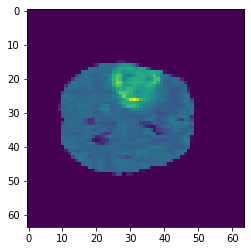

In [ ]:
# from monai.data import create_test_image_2d, list_data_collate, decollate_batch

# # split into training, val, testing
# train_dataset, val_dataset = torch.utils.data.random_split(train_5, (200, 100))
# val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, (50, 50))

# # define dataset, data loader
# #new_ds = monai.data.Dataset(data=train_5, transform=train_transforms)
# #new_loader = DataLoader(new_ds, batch_size=1, num_workers=1)

# # create a trainng data loader
# train_ds = monai.data.Dataset(data=train_dataset, transform=train_transforms)
# train_loader = DataLoader(
#     train_ds,
#     batch_size=1,
#     shuffle=False,
#     num_workers=1,
#     collate_fn=list_data_collate,
#     pin_memory=torch.cuda.is_available(),
# )

# val_ds = monai.data.Dataset(data=val_dataset, transform=train_transforms)
# val_loader = DataLoader(
#     val_ds,
#     batch_size=1,
#     shuffle=False,
#     num_workers=1,
#     collate_fn=list_data_collate,
#     pin_memory=torch.cuda.is_available(),
# )

# test_ds = monai.data.Dataset(data=test_dataset, transform=train_transforms)
# test_loader = DataLoader(
#     test_ds,
#     batch_size=1,
#     shuffle=False,
#     num_workers=1,
#     collate_fn=list_data_collate,
#     pin_memory=torch.cuda.is_available(),
# )

first = monai.utils.misc.first(new_loader)
print(first["img"].shape, first["seg"].shape)

plt.imshow(first["img"][0,0,...,16])  # you can compare this from https://socr.umich.edu/HTML5/BrainViewer/
# without split the data and shuffle item, the orders of image here is the same as their original id (original id refers to "Task01_BrainTumour/imagesTr/BRATS_278.nii.gz")

# Unsupervised Deep Clustering
- part A: target (dominant class within superpixel)
- part B: clustering CNN (loss?)

##CNN architecture with weight initalization

In [ ]:
from google.colab import output
class clusteringCNN(nn.Module):
    # initializers
    def __init__(self,num_modality,output_channel):
        super(clusteringCNN, self).__init__()
        #TODO
        # Note: input and the output should be the same size,
        # in order to do the superpixel step
        # WHY? before I used stride=0, padding=0, as parameters in paper but it gives me error: pytorch conv3d non-postive stride is not supported (which didn't make sense)
        self.layer1 =nn.Conv3d(in_channels=num_modality, out_channels=100, kernel_size=3, stride=1, padding=1)  #[Batch, Channel, Slice, H, W]
        self.bn1 = torch.nn.InstanceNorm3d(100)
        self.layer2 = nn.Conv3d(100, 100, 3, stride=1, padding=1)
        self.bn2 = torch.nn.InstanceNorm3d(100)
        self.layer3 = nn.Conv3d(100, output_channel, 3, stride=1, padding=1)
        self.bn3 = torch.nn.InstanceNorm3d(output_channel) 

        
    # Init linear layers
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        #TODO
        x = input
        x = self.bn1(nn.functional.relu(self.layer1(x)))
        x = self.bn2(nn.functional.relu(self.layer2(x)))
        x = self.bn3(self.layer3(x))
        # x,_ = torch.argmax(x, dim=1) # don't need argmax in the training, we only need it in creating target
        return x

## Create target

In [ ]:
from skimage.segmentation import slic, mark_boundaries
import torch.nn.functional as F

def GenerateTarget(original_input, batch,  clusterCNN_output):
  '''
  NOTE: might need to modify some code if batch_size > 1
  step A: draw superpixels on original image
  step B: apply superpixels on model_output to "segment" different parts
  step C: copy a zero tensor as model_output 
  step D: for each superpixel/part:
            find the mode in that part,
            fill the mode all over that part
          generate the tensor filled in the modes
  step E: now have the pesudolabel out of the superpixels and cluster CNN
  @params: 
  original_input: original image [B, C=1/FLAIR, H, W, Slice] 
  clusterCNN_output: pred from clustering CNN in [B, Cluster, Slice, H, W]
  @output: 
  [B, H, W, Slice, C=1] 
  '''
  ## STEP A
  #print("-------new image----------")
  original_input2 = original_input/255 # size of [B, C, Slice, H, W]
  input_super = slic(original_input2[batch,0,...].detach().cpu().numpy(), multichannel=False, convert2lab=True,n_segments=500, sigma=1, enforce_connectivity=False, compactness=0.0001) # 64, 64, 32
  
  ## STEP B
  input_super_tensor = torch.from_numpy(input_super)
  input_super_onehot = F.one_hot(input_super_tensor, num_classes = -1)
  #print("input_super_onehot.size(): the index 3 should be num_superpixels", input_super_onehot.size()) #[64, 64, 32, 943(x)]
  num_superpixel = input_super_onehot.size(3)
  #print("num_superpixel:", num_superpixel)
  # for i in range(num_superpixel):
  #   if i < 503:
  #     plt.figure()
  #     plt.imshow(input_super_onehot[...,16,i])
  #     plt.colorbar()
  # print("final i:", i)


  ## STEP C
  temp = torch.clone(input_super_onehot) # [H, W, Slice, Num_superclass]

  ## STEP D
  clusterCNN_output_argmax = torch.argmax(clusterCNN_output,dim=1,keepdim= True)+1 #+1 in order to find mode, no mess up with other meaning of 0(one hot encoding og label)

  for i in range(num_superpixel):
    plus = torch.mul(clusterCNN_output_argmax.to('cuda'),input_super_onehot[...,i].to('cuda'))
    plus2 = torch.reshape(plus, (-1,))
    mode_i, _ = torch.mode(plus2[plus2!=0])
    mode_i3 = mode_i.long()
    #print("#", i, "superpixel", "mode is:", mode_i3) # mode_i should be something 1~x(num of cluster)
    temp[...,i][temp[...,i]!=0] = mode_i3-1 # delete the 1 which we add before
  pesudolabel = torch.sum(temp, dim=3, keepdim=True) # [64, 64, 32, 1]
  return pesudolabel


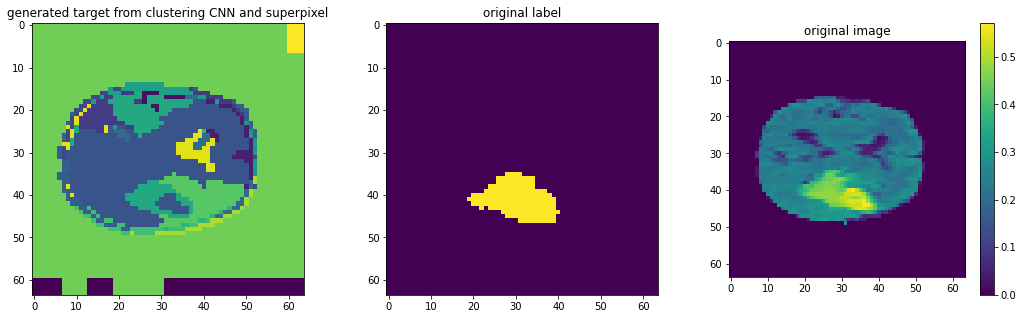

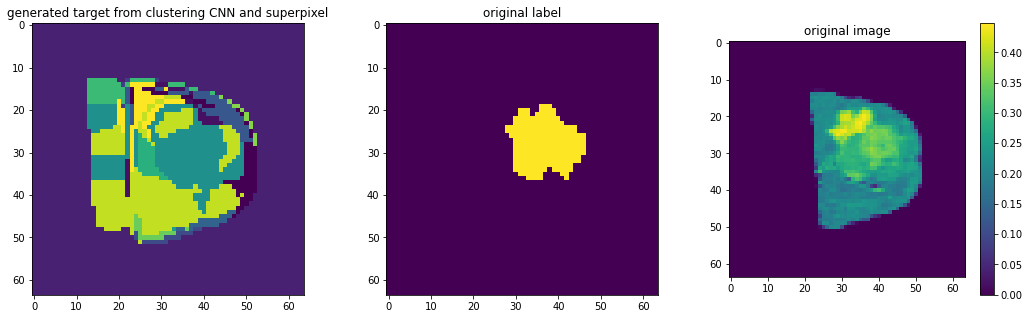

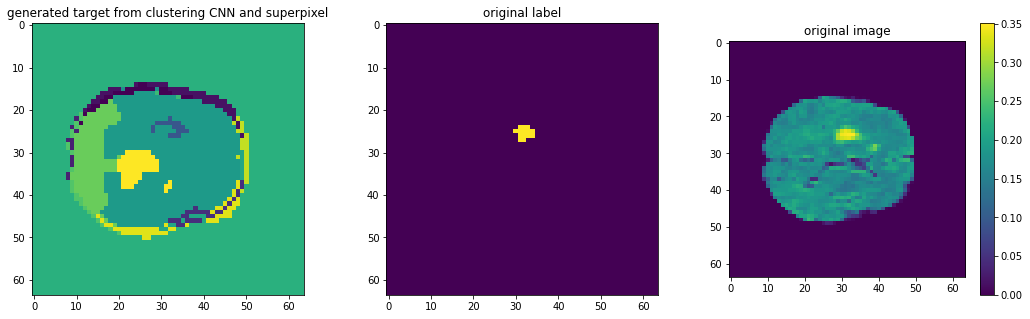

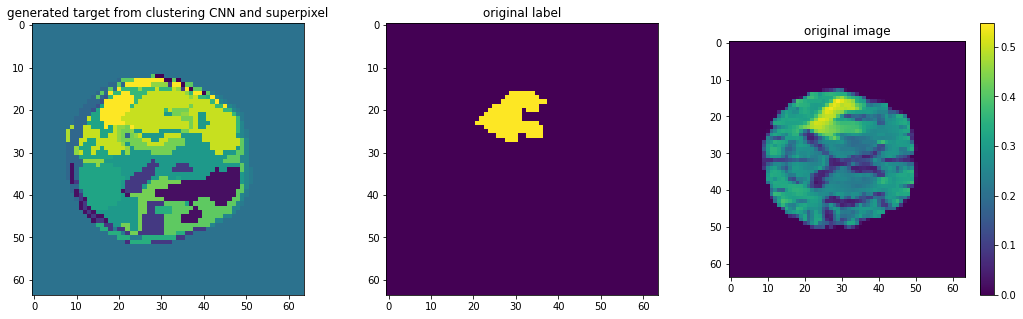

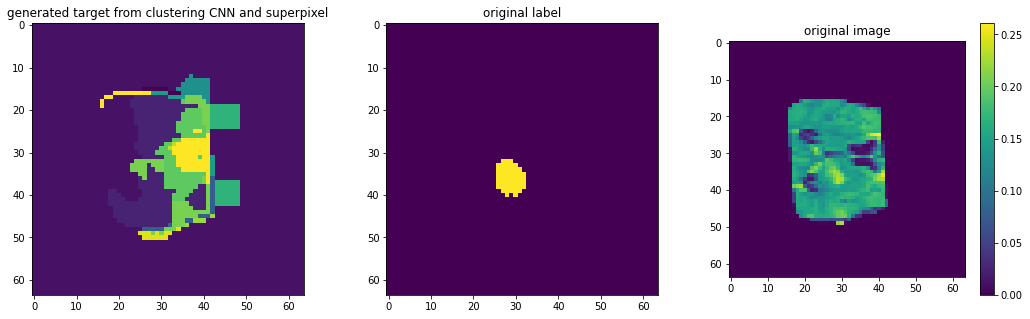

In [ ]:
# use five image for test
for i,single in enumerate(new_loader): 
  if i <5:
    x = single["img"]
    y = single['seg']
    # print("x.size():", x.size()) # [1, 4, 64, 64, 32]
    # print("y.size():", y.size()) # [1, 4, 64, 64, 32]

    num_modality = 1
    num_cluster = 25
    batch = 0
    model = clusteringCNN(num_modality,num_cluster).to('cuda')
    pred_cnn = model(x.to('cuda'))
    test_single = GenerateTarget(x.to('cuda'), batch, pred_cnn)
    
    plt.subplots(1,3,figsize=(18,5))
    plt.subplot(1,3, 1);plt.imshow(test_single[...,16,0]);plt.title("generated target from clustering CNN and superpixel")
    plt.subplot(1,3, 2);plt.imshow(y[0,0,:,:,16]);plt.title("original label")
    plt.subplot(1,3, 3);plt.imshow(x[0,0,:,:,16]);plt.title("original image")
    plt.colorbar()
  else:
    break

## initiate model

In [ ]:
# learning_rate=0.001 # following comment setting perform well than current one but current one is the recommendation from paper
learning_rate=0.1

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

use_gpu=True
cuda0 = torch.device('cuda:0')

## Initialize your unet
n_modality = 1
n_classes = 6
model = clusteringCNN(n_modality, n_classes)

## Initialize Optimizer and Learning Rate Scheduler
#optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss = torch.nn.CrossEntropyLoss()

Device cuda


## training model with all images

In [ ]:
from logging import PercentStyle
from time import time

print("Start Training...")


early_stopping=False
min_val=1000
num_epoch_converge=0
num_epochs=20

best_val_dice = 0
if use_gpu:
    model.to(device)
counter = 0
total_train_loss = []

time1 = time()
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    
    # TODO: Design your own training section
    loss_per_batch=[]
    for j,batch in enumerate(new_loader):
      inputs = batch["img"] # size of [B, Slice, H, W]
      if j % 25==0: print('batch:',j)
      for batch in range(inputs.size(0)): 
        # generate target
        model.train()
        clusterCNN_output = model(inputs.to(device)) #[B, Cluster, H, W, Slice] [1, 25, 64, 64, 32]
        with torch.no_grad():
          pesudolabel = GenerateTarget(inputs, batch, clusterCNN_output) #[64, 64, 32, 1]
          pesudolabel2 = torch.permute(pesudolabel,(3,0,1,2)) #[1, 64, 64, 32]
                    
        
        counter += 1
        # if counter == 8: # same as batch size = 8
        optimizer.zero_grad()
        model_loss = loss(clusterCNN_output.to(device),pesudolabel2.to(device)) 
        model_loss.backward()
        optimizer.step()
        # counter =0

        loss_per_batch.append(model_loss.item())
    total_train_loss.append(loss_per_batch)
    # for _, batch in enumerate(val_loader):
    #   inputs = batch['img']
    #   for batch in range(inputs.size(0)):
    #     model.eval()
    #     clusterCNN_output = model(inputs.to(device))
    #     with torch.no_grad():
    #       pesudolabel = GenerateTarget(inputs, batch, clusterCNN_output) 
    #       pesudolabel2 = torch.permute(pesudolabel,(3,0,1,2))

time2 = time()
print('running time for clustering CNN and generation of target for all epochs:', time2-time1)
        #print('loss_per_batch:',model_loss.item())

Start Training...

EPOCH 1 of 20

batch: 0
batch: 25
batch: 50

EPOCH 2 of 20

batch: 0
batch: 25
batch: 50

EPOCH 3 of 20

batch: 0
batch: 25
batch: 50

EPOCH 4 of 20

batch: 0
batch: 25
batch: 50

EPOCH 5 of 20

batch: 0
batch: 25
batch: 50

EPOCH 6 of 20

batch: 0
batch: 25
batch: 50

EPOCH 7 of 20

batch: 0
batch: 25
batch: 50

EPOCH 8 of 20

batch: 0
batch: 25
batch: 50

EPOCH 9 of 20

batch: 0
batch: 25
batch: 50

EPOCH 10 of 20

batch: 0
batch: 25
batch: 50

EPOCH 11 of 20

batch: 0
batch: 25
batch: 50

EPOCH 12 of 20

batch: 0
batch: 25
batch: 50

EPOCH 13 of 20

batch: 0
batch: 25
batch: 50

EPOCH 14 of 20

batch: 0
batch: 25
batch: 50

EPOCH 15 of 20

batch: 0
batch: 25
batch: 50

EPOCH 16 of 20

batch: 0
batch: 25
batch: 50

EPOCH 17 of 20

batch: 0
batch: 25
batch: 50

EPOCH 18 of 20

batch: 0
batch: 25
batch: 50

EPOCH 19 of 20

batch: 0
batch: 25
batch: 50

EPOCH 20 of 20

batch: 0
batch: 25
batch: 50
running time for clustering CNN and generation of target for all epochs

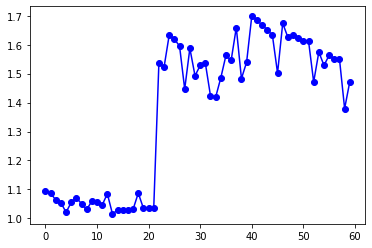

In [ ]:
plt.plot(loss_per_batch, '-o', label="train loss", color='blue')

In [ ]:
plt.savefig('loss in last epoch of clustering CNN.png')

<Figure size 432x288 with 0 Axes>

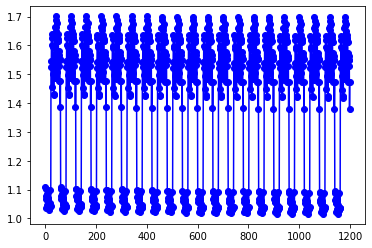

In [ ]:
flat_total_loss = []
for sublist in total_train_loss:
  for item in sublist:
    flat_total_loss.append(item)
plt.plot(flat_total_loss, '-o', label="total train loss", color='blue')

In [ ]:
plt.savefig('total loss of clustering CNN.png')

## Save/load model

In [ ]:
torch.save(model,'/content/clusteringCNN-flair0503.pt') 
# model = torch.load('/content/clusteringCNN-flair0503.pt')

# Caculate the Score

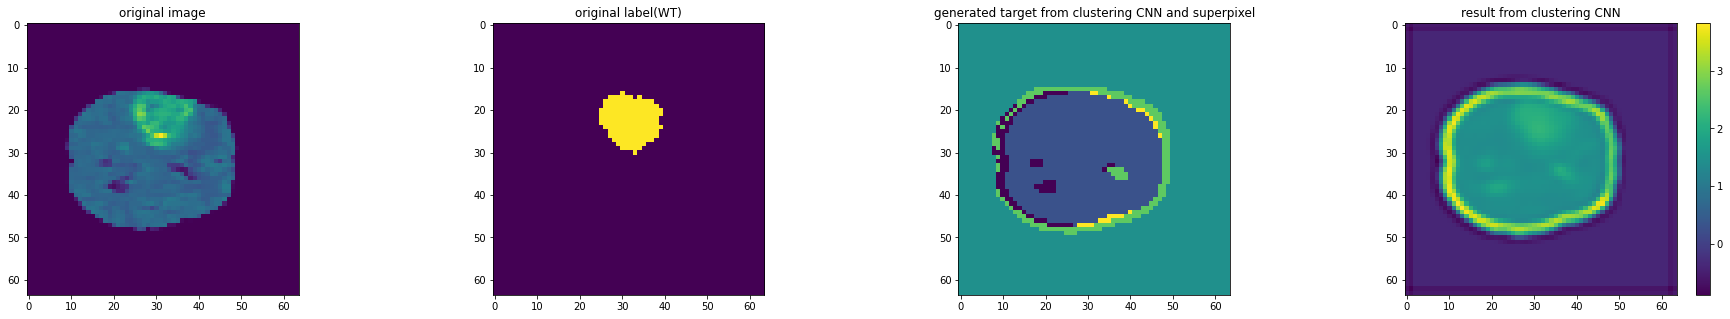

In [ ]:
from torch.autograd import Variable

# test saved model in one image
plt.subplots(1,4,figsize=(32,5))
pred = model(Variable(first['img'].cuda(), requires_grad=True))
pesudolabel = GenerateTarget(first['img'], 0, pred)
batch = 0
plt.subplot(1,4, 2);plt.imshow(first['seg'].detach().cpu().numpy()[batch,0,...,16]);plt.title("original label(WT)")
plt.subplot(1,4, 1);plt.imshow(first['img'].detach().cpu().numpy()[batch,0,...,16]);plt.title("original image")
plt.subplot(1,4, 3);plt.imshow(pesudolabel[...,16,0]);plt.title("generated target from clustering CNN and superpixel")
plt.subplot(1,4,4);plt.imshow(pred[batch,0,...,16].cpu().detach().numpy());plt.title("result from clustering CNN")
plt.colorbar()


## DICE Score for one image

In [ ]:
from collections import defaultdict

def dice_score_image(pesudo, truelabel):
  '''
    computer the mean dice score for every class in a single image

    Args:
        pesudo(tensor): predictied labels of the image, [H, W, Slice, C=1] (before one hot)
        truelabel (tensor): ground truth of the image [B, C=1, H, W, Slice] when choosing C=0, it is the whole tumor we want
  
    Returns:
        one_score_list: dict {index of class(int): dice score for that class (float)}(for one image)
  '''

  pesudo_onehot = F.one_hot(pesudo, num_classes=6) #[H, W, Slice, 1, C=25]
  class25 = pesudo_onehot.size(4) 
  assert class25 == 6 # should be 25
  
  pesudo2_onehot = torch.permute(pesudo_onehot, (3,0,1,2,4)) #[B, H,W,Slice,Class=24]
  truelabel2 = torch.permute(truelabel,(0,2,3,4,1)) 
  #print("truelabel2.size():", truelabel2.size()) # it should be [B, H, W, Slice, C=1]
  truelabel_flat = truelabel2[0,...].contiguous().view(-1) #chose whole tumor

  one_score_list = defaultdict()
  for i in range(class25):
    pesudo_i_flat = pesudo2_onehot[0,...,i].contiguous().view(-1)
    TP_i = ((pesudo_i_flat == 1) * (truelabel_flat == 1)).sum().item()
    FP_i = ((pesudo_i_flat == 1) * (truelabel_flat != 1)).sum().item()
    FN_i = ((pesudo_i_flat != 1) * (truelabel_flat == 1)).sum().item()
    cal = (2 * TP_i) / (2 * TP_i + FP_i + FN_i)
    one_score_list[i] = cal 

  return one_score_list

In [ ]:
# test Dice score in one target
dice_score_image(pesudolabel,first['seg'])

defaultdict(None,
            {0: 0.0,
             1: 0.021882741535920725,
             2: 0.22728183214261868,
             3: 0.0,
             4: 0.0008041817450743868,
             5: 0.0017528483786152498})

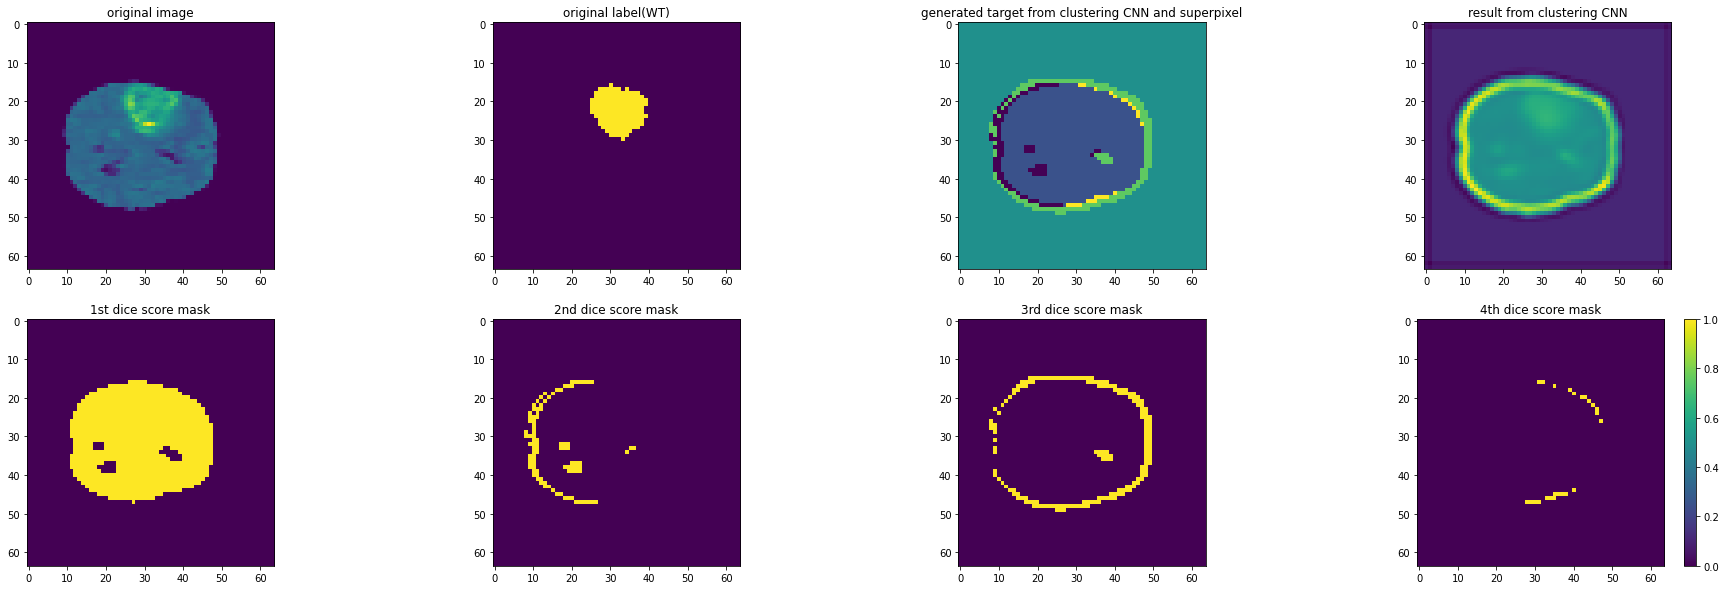

In [ ]:
# test Dice score in one target

plt.subplots(2,4,figsize=(32,10))
pesudo_onehot = F.one_hot(pesudolabel, num_classes=-1)
plt.subplot(2,4, 2);plt.imshow(first['seg'].detach().cpu().numpy()[batch,0,...,16]);plt.title("original label(WT)")
plt.subplot(2,4, 1);plt.imshow(first['img'].detach().cpu().numpy()[batch,0,...,16]);plt.title("original image")
plt.subplot(2,4, 3);plt.imshow(pesudolabel[...,16,0]);plt.title("generated target from clustering CNN and superpixel")
plt.subplot(2,4,4);plt.imshow(pred[batch,0,...,16].cpu().detach().numpy());plt.title("result from clustering CNN")
plt.subplot(2,4, 5);plt.imshow(pesudo_onehot[...,16,0,2].detach().cpu().numpy());plt.title("1st dice score mask")
plt.subplot(2,4, 6);plt.imshow(pesudo_onehot[...,16,0,1].detach().cpu().numpy());plt.title("2nd dice score mask")
plt.subplot(2,4, 7);plt.imshow(pesudo_onehot[...,16,0,4].detach().cpu().numpy());plt.title("3rd dice score mask")
plt.subplot(2,4,8);plt.imshow(pesudo_onehot[...,16,0,5].cpu().detach().numpy());plt.title("4th dice score mask")
plt.colorbar()

## DICE Score for all images

In [ ]:
def dice_score_all(data_loader):
  all_score_list = defaultdict()
  for i,single in enumerate(data_loader):
    pred_i = model(Variable(single['img'].cuda(), requires_grad = False))
    pesudo_i = GenerateTarget(single['img'], 0, pred_i)
    truelabel_0 = single['seg']
    one_image_score = dice_score_image(pesudo_i,truelabel_0)
    all_score_list[i] = one_image_score
  return all_score_list


In [ ]:
result = dice_score_all(new_loader)

In [ ]:
result

defaultdict(None,
            {0: defaultdict(None,
                         {0: 0.0,
                          1: 0.021882741535920725,
                          2: 0.22728183214261868,
                          3: 0.0,
                          4: 0.0008041817450743868,
                          5: 0.0017528483786152498}),
             1: defaultdict(None,
                         {0: 0.0,
                          1: 0.004168002564924655,
                          2: 0.33469633193024656,
                          3: 0.0,
                          4: 0.04659014179608373,
                          5: 0.04826073331244124}),
             2: defaultdict(None,
                         {0: 0.0,
                          1: 0.055938697318007664,
                          2: 0.21888717522837822,
                          3: 0.0,
                          4: 0.002530044275774826,
                          5: 0.0070577856197618}),
             3: defaultdict(None,
                         {0: 

In [ ]:
test_result = dice_score_all(test_loader)

In [ ]:
test_result

defaultdict(None,
            {0: defaultdict(None,
                         {0: 0.0,
                          1: 0.2178988326848249,
                          2: 0.8014605203103605,
                          3: 0.0,
                          4: 0.14959016393442623,
                          5: 0.0}),
             1: defaultdict(None,
                         {0: 0.0,
                          1: 0.210016155088853,
                          2: 0.7316933638443935,
                          3: 0.0,
                          4: 0.23853606027987082,
                          5: 0.0}),
             2: defaultdict(None,
                         {0: 0.0,
                          1: 0.2421917808219178,
                          2: 0.8049180327868852,
                          3: 3.0998140111593304e-05,
                          4: 0.10980392156862745,
                          5: 0.0}),
             3: defaultdict(None,
                         {0: 0.0,
                          1: 0.1820728